<a href="https://colab.research.google.com/github/lskaa0111/Machine-Learning/blob/main/Replicate_Paper_by_Rapach%2C_Strauss%2C_Tu%2C_Zhou_4_Way_Classification(updated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Replicate [Dynamic Return Dependencies Across Industries: A Machine Learning Approach](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3120110&download=yes) by David Rapach, Jack Strauss, Jun Tu and Guofu Zhou.

Use classification instead of linear regression 
   - Construct response variable with 4 classes by performance quartile. 
   - Construct classification models that minimize cross-entropy vs. 4-class response variable

1) Off-the shelf sklearn algorithms

2) Popular boosting algorithms: XGBoost, CatBoost, LightGBM. These algorithms tend to be faster and more tuneable than the off-the-shelf sklearn classification models, are often used in Kaggle contests

3) Keras neural net classification model

4) Classification models aren't rank-aware. Misclassifying a true long as flat is penalized the same as misclassifying a true long as short. Improve NN model with a custom loss function to increase the penalty for the worst misclassifications. The hope is that this decreases overall classification accuracy but improve portfolio performance.

5) Instead of top 6 - bottom 6, cross-validate thresholds.
 
Adding additional real economy and financial market predictors, and using an ensemble with cross-validation, we get Sharpes exceeding 0.8%.


In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import pandas_datareader.data as datareader
import time 
import datetime
import copy
import random
from itertools import product

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy numpy warnings

# turn off all the warnings
# still some warnings about deprecation, truth value of an array and whatnot
#if not sys.warnoptions:
warnings.simplefilter("ignore")
    
import sklearn
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_squared_error, explained_variance_score, r2_score, accuracy_score
from sklearn.linear_model import LinearRegression, Lasso, lasso_path, lars_path, LassoLarsIC, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import all_estimators

In [20]:


# other popular gradient boost algorithms
# XGBoost https://xgboost.readthedocs.io/en/latest/
import xgboost 
# Yandex CatBoost https://catboost.yandex/
import catboost 
# Microsoft LightGbm https://lightgbm.readthedocs.io/en/latest/
import lightgbm as lgb 

from scipy.stats import chisquare, kendalltau

import tensorflow as tf
from keras.models import load_model, Model
from keras import backend as K
#with tf.device('/job:localhost/replica:0/task:0/device:CPU:0'):
with tf.device('/device:GPU:0'):
    tf.random.set_seed(1764)
    print(tf.__version__)
    # confirm GPU is in use
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

    sess = tf.compat.v1.Session()




from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense, Activation
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.python.keras.regularizers import l1
from tensorflow.python.keras import backend as K
# K.set_session(sess)
### sess = tf.compat.v1.Session()
## K.set_session(sess)    
#import ffn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# this will make dataframe display as sortable widget
# commented out because sortable tables not viewable using nbviewer
# from beakerx import *

import plotly
# print (plotly.__version__) # requires version >= 1.9.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

random.seed(1746)
np.random.seed(1746)



2.8.0


In [3]:
pip install catboost

     |████████████████████████████████| 76.6 MB 54 kB/s 


In [5]:
pip install xgboost

In [24]:
print("Loading data...")
data = pd.read_csv("30_Industry_Portfolios.csv")
data = data.set_index('yyyymm')
industries = list(data.columns)
# map industry names to col nums
ind_reverse_dict = dict([(industries[i], i) for i in range(len(industries))])

rfdata = pd.read_csv("F-F_Research_Data_Factors.csv")
rfdata = rfdata.set_index('yyyymm')
data['rf'] = rfdata['RF']

# subtract risk-free rate
# create a response variable led by 1 period to predict
for ind in industries:
    data[ind] = data[ind] - data['rf']
    
for ind in industries:
    data[ind+".lead"] = data[ind].shift(-1)

data = data.loc[data.index[data.index > 195911]]
data = data.drop(columns=['rf'])    
data = data.dropna(axis=0, how='any')

# add some additional fundamental predictors
# download from FRED using pandas datareader

start_date = datetime.datetime(1926, 9, 1)
end_date = datetime.datetime(2017, 12, 1)
# 3M
TB3MS = datareader.DataReader("TB3MS", "fred", start_date, end_date)
TB3MS['yyyymm'] = TB3MS.index.strftime('%Y%m')
TB3MS['yyyymm'] = [int(datestr) for datestr in TB3MS['yyyymm']]
TB3MS=TB3MS.set_index(['yyyymm'])
data['3month']=TB3MS['TB3MS'].diff()

#10Y
GS10 = datareader.DataReader("GS10", "fred", start_date, end_date)
GS10['yyyymm'] = GS10.index.strftime('%Y%m')
GS10['yyyymm'] = [int(datestr) for datestr in GS10['yyyymm']]
GS10=GS10.set_index(['yyyymm'])
data['10year']=GS10['GS10'].diff()

#industrial production
INDPRO = datareader.DataReader("INDPRO", "fred", start_date, end_date)
INDPRO['yyyymm'] = INDPRO.index.strftime('%Y%m')
INDPRO['yyyymm'] = [int(datestr) for datestr in INDPRO['yyyymm']]
INDPRO=INDPRO.set_index(['yyyymm'])
data['indprod']=INDPRO['INDPRO'].pct_change(periods=12)

#inflation
CPIAUCNS = datareader.DataReader("CPIAUCNS", "fred", start_date, end_date)
CPIAUCNS['yyyymm'] = CPIAUCNS.index.strftime('%Y%m')
CPIAUCNS['yyyymm'] = [int(datestr) for datestr in CPIAUCNS['yyyymm']]
CPIAUCNS=CPIAUCNS.set_index(['yyyymm'])
data['CPI']=CPIAUCNS['CPIAUCNS'].pct_change(periods=12)

# yield curve
data['curve'] = data['10year'] - data['3month']

# overall market return
data['Mkt-RF'] = rfdata['Mkt-RF']

# month dummies
data['month'] = data.index  % 100 # for possible seasonality
month_dummy = tf.keras.utils.to_categorical(data['month'])


for i in range(month_dummy.shape[1]):
    data['month_dummy_%02d' % i] = month_dummy[:,i]
data = data.drop(columns=['month']) 

# reorder so responses are at the end
data = data [['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other', '3month',
       '10year', 'curve', 'Mkt-RF', 'indprod', 'CPI', 'month_dummy_00', 'month_dummy_01',
       'month_dummy_02', 'month_dummy_03', 'month_dummy_04', 'month_dummy_05',
       'month_dummy_06', 'month_dummy_07', 'month_dummy_08', 'month_dummy_09',
       'month_dummy_10', 'month_dummy_11', 'month_dummy_12', 'Food.lead',
       'Beer.lead', 'Smoke.lead', 'Games.lead', 'Books.lead', 'Hshld.lead',
       'Clths.lead', 'Hlth.lead', 'Chems.lead', 'Txtls.lead', 'Cnstr.lead',
       'Steel.lead', 'FabPr.lead', 'ElcEq.lead', 'Autos.lead', 'Carry.lead',
       'Mines.lead', 'Coal.lead', 'Oil.lead', 'Util.lead', 'Telcm.lead',
       'Servs.lead', 'BusEq.lead', 'Paper.lead', 'Trans.lead', 'Whlsl.lead',
       'Rtail.lead', 'Meals.lead', 'Fin.lead', 'Other.lead', ]]

nresponses = len(industries)
npredictors = data.shape[1]-nresponses

predictors = list(data.columns[:npredictors])
predictor_reverse_dict = dict([(predictors[i], i) for i in range(len(predictors))])

responses = list(data.columns[-nresponses:])
response_reverse_dict = dict([(responses[i], i) for i in range(len(responses))])

print(data.shape)

data[['Food', 'Food.lead']]


Loading data...
(697, 79)


,Food,Food.lead
yyyymm,,
195912,2.01,-4.49
196001,-4.49,3.35
196002,3.35,-1.67
196003,-1.67,1.17
196004,1.17,8.20
...,...,...
201708,-2.77,0.43
201709,0.43,0.71
201710,0.71,4.15


In [ ]:
data['CPI']

In [26]:
# first training row: forecast for 196001 using 195912
data = data.loc[data.index[data.index > 195911]]
print(data[responses].columns)
print(data[predictors].columns)
data

Index(['Food.lead', 'Beer.lead', 'Smoke.lead', 'Games.lead', 'Books.lead',
       'Hshld.lead', 'Clths.lead', 'Hlth.lead', 'Chems.lead', 'Txtls.lead',
       'Cnstr.lead', 'Steel.lead', 'FabPr.lead', 'ElcEq.lead', 'Autos.lead',
       'Carry.lead', 'Mines.lead', 'Coal.lead', 'Oil.lead', 'Util.lead',
       'Telcm.lead', 'Servs.lead', 'BusEq.lead', 'Paper.lead', 'Trans.lead',
       'Whlsl.lead', 'Rtail.lead', 'Meals.lead', 'Fin.lead', 'Other.lead'],
      dtype='object')
Index(['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other', '3month', '10year',
       'curve', 'Mkt-RF', 'indprod', 'CPI', 'month_dummy_00', 'month_dummy_01',
       'month_dummy_02', 'month_dummy_03', 'month_dummy_04', 'month_dummy_05',
       'month_dummy_06', 'month_dummy_07', 'month_dummy_

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
yyyymm,,,,,,,,,,,,,,,,,,,,,
195912,2.01,0.35,-3.02,1.64,7.29,0.67,1.87,-1.97,3.08,0.74,...,0.62,-6.18,-7.93,-9.41,-4.31,-5.33,-6.09,-10.08,-4.68,-3.98
196001,-4.49,-5.71,-2.05,1.21,-5.47,-7.84,-8.53,-6.68,-10.03,-4.77,...,8.07,9.13,5.09,3.00,-0.94,1.42,4.00,1.81,-0.98,6.32
196002,3.35,-2.14,2.27,4.23,2.39,9.31,1.44,-0.02,-0.74,0.32,...,-0.21,-0.31,3.34,-2.43,-4.99,-1.37,-0.13,-3.88,0.05,-2.43
196003,-1.67,-2.94,-0.18,-0.65,2.18,-0.56,-2.59,1.26,-2.75,-6.79,...,-1.24,7.14,1.77,0.41,-2.13,0.45,-0.53,8.86,-0.64,0.55
196004,1.17,-2.16,1.35,6.46,-1.17,-1.27,0.21,1.49,-5.53,-1.10,...,3.05,-1.75,11.90,2.85,0.90,1.65,3.11,0.80,-0.45,1.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201708,-2.77,0.94,-0.96,-1.78,-6.37,-0.04,-5.79,1.69,1.52,2.62,...,-1.68,0.60,0.80,2.44,6.20,4.46,2.71,0.79,5.07,0.99
201709,0.43,-3.00,-2.13,3.66,3.54,-0.21,1.01,1.40,6.58,0.45,...,-5.75,5.93,7.12,4.28,-1.99,-1.18,3.22,3.64,3.22,-1.20
201710,0.71,1.24,-2.90,2.02,-1.90,-3.09,3.47,-2.35,5.52,1.23,...,3.91,0.05,2.41,4.21,6.66,3.37,9.38,5.45,3.76,1.60


In [27]:
data.to_csv("data.csv")
desc = data.describe()
desc
# min, max line up with Table 1

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm.lead,Servs.lead,BusEq.lead,Paper.lead,Trans.lead,Whlsl.lead,Rtail.lead,Meals.lead,Fin.lead,Other.lead
count,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,...,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000
mean,0.688666,0.727030,0.985079,0.732095,0.532253,0.564333,0.690387,0.665825,0.552367,0.687145,...,0.515968,0.729928,0.622970,0.534806,0.601090,0.631076,0.698235,0.728766,0.637547,0.396628
std,4.308660,5.058992,6.032324,7.128170,5.780362,4.728000,6.355251,4.897557,5.482363,6.970961,...,4.607931,6.486956,6.698787,5.021876,5.707154,5.571040,5.334178,6.065564,5.381389,5.771655
min,-18.150000,-20.190000,-25.320000,-33.400000,-26.560000,-22.240000,-31.500000,-21.060000,-28.600000,-33.110000,...,-16.440000,-28.670000,-32.070000,-27.740000,-28.500000,-29.250000,-29.740000,-31.890000,-22.530000,-28.090000
25%,-1.630000,-2.080000,-2.740000,-3.390000,-2.600000,-2.030000,-2.800000,-2.230000,-2.750000,-3.170000,...,-2.110000,-3.050000,-3.220000,-2.400000,-2.780000,-2.560000,-2.380000,-2.840000,-2.400000,-2.930000
50%,0.740000,0.750000,1.270000,0.940000,0.510000,0.750000,0.700000,0.760000,0.720000,0.640000,...,0.590000,1.010000,0.670000,0.710000,0.900000,0.940000,0.540000,1.080000,0.870000,0.540000
75%,3.070000,3.690000,4.660000,5.260000,3.640000,3.540000,4.310000,3.550000,3.760000,4.480000,...,3.360000,4.260000,4.630000,3.460000,4.040000,3.880000,3.980000,4.300000,4.000000,4.200000
max,19.890000,25.510000,32.380000,34.520000,33.130000,18.220000,31.790000,29.010000,21.680000,59.030000,...,21.220000,23.380000,24.660000,21.000000,18.500000,17.530000,26.490000,27.380000,20.590000,19.960000


In [28]:
X = data.values[:,:npredictors]
Y = data.values[:,-nresponses:]
nrows = X.shape[0]
X.shape

(697, 49)

In [29]:
# first iteration will train up to including 196911
# will use 196912 to predict 197001
# 1970101 will be first month of performance to use
# train on first 121 months up to 196912 (0:120), put first prediction in P[121] (122nd row)
# first month of performance will be 197002
FIRST_TRAIN_MONTHS = 121
FIRST_PREDICT_MONTH = FIRST_TRAIN_MONTHS # This is stupid but keeps my head straight

print(X[FIRST_TRAIN_MONTHS])
print(data.iloc[FIRST_TRAIN_MONTHS][:30])

[-3.34000000e+00 -1.95000000e+00 -7.59000000e+00 -7.76000000e+00
 -1.20500000e+01 -7.50000000e+00 -5.69000000e+00 -7.71000000e+00
 -7.37000000e+00 -5.26000000e+00 -9.84000000e+00 -6.31000000e+00
 -7.15000000e+00 -6.89000000e+00 -9.35000000e+00 -1.24900000e+01
 -2.34000000e+00 -7.70000000e-01 -1.21600000e+01 -4.83000000e+00
 -3.16000000e+00 -1.11700000e+01 -9.73000000e+00 -8.89000000e+00
 -8.17000000e+00 -8.28000000e+00 -6.31000000e+00 -1.31200000e+01
 -9.78000000e+00 -6.20000000e+00  5.00000000e-02  1.40000000e-01
  9.00000000e-02 -8.10000000e+00 -6.75853480e-03  6.17977528e-02
  0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
Food     -3.34
Beer     -1.95
Smoke    -7.59
Games    -7.76
Books   -12.05
Hshld    -7.50
Clths    -5.69
Hlth     -7.71
Chems    -7.37
Txtls    -5.26
Cnstr    -9.84
Steel    -6.31
FabPr    -7.15
ElcEq  

In [30]:
class PredictWrapper():
    """Wrap an sklearn model e.g. LinearRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it"""

    def __init__(self, create_model, coef_dict, fit_missing=None):
        self.create_model = create_model        
        self.coef_dict = coef_dict
        self.fit_missing = fit_missing
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            if self.coef_dict[responsecol]:
                # column indexes to fit against each other
                predcols = self.coef_dict[responsecol]
            else: # no columns selected
                if not self.fit_missing:
                    # default: don't fit if no predictors selected
                    self.models.append(None)
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "mean":
                    # append a numeric value to use
                    self.models.append(np.mean(Y_fit[:,responsecol]))
                    #print(self.models[-1])
                    continue
                elif self.fit_missing == "all":
                    # predcols = all columns
                    predcols = range(X_fit.shape[1])

            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit[:, predcols], Y_fit[:,responsecol])
            if verbose:
                print("fit on " + str(X_fit[:, predcols].shape) + str(predcols))
                print(model.coef_)
                            
            self.models.append(model)
                
            #debug
            #print(responsecol)
            #print(X_fit[:, predcols])
            #print("=====")
            #print(Y_fit[:,responsecol])
            #print("=====")
            #print(self.model.coef_)
            #print(self.model.intercept_)
            #print("=====")                

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            #print (type(self.models[responsecol]))
            if type(self.models[responsecol]) == np.float64:
                pred = np.array([self.models[responsecol]] * nrows).reshape(nrows,1)
                predictions.append(pred)
                sys.stdout.write('\010#')
            elif not self.models[responsecol]: 
                # don't predict
                predictions.append(np.array([np.nan] * nrows ).reshape(nrows,1))
                sys.stdout.write('\010N')
            else:
                predcols = self.coef_dict[responsecol]
                y_pred = self.models[responsecol].predict(X_predict[:,predcols])
                if verbose:
                    print("predict on" + str(X_predict[:, predcols].shape) + str(predcols))
                    print(y_pred)
                predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
        

In [32]:
class ClassifyWrapper():
    """Wrap an sklearn model e.g. LogisticRegression to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, create_model):
        self.create_model = create_model        
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            model = self.create_model() # create 1 sklearn model for each column
            model.fit(X_fit, Y_fit[:,responsecol])
            self.models.append(model)

    def predict(self, X_predict, verbose=False):

        predictions = []
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            #print(y_pred.shape)
            predictions.append(y_pred.reshape(nrows,1))
        
        return np.hstack(predictions)
        
    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict_proba(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]
        
        

### BacktestModel class to abstract walk-forward validation and backtesting workflow from modeling, portfolio construction, reporting

In [31]:
# typical pipeline
# backtestmodel = BacktestModel(X, # predictors
#                              Y, # responses
#                              create_model=LinearRegression, # create_model which returns a model (needed for 'timestep' which creates different model each timestep)
#                              # or model = someKerasModel, # initialized model that supports fit(X,Y), predict(X) , predicts an entire row,
#                              coef_dict_param=coef_dict_paper, # how to map predictors to responses ("all", "timestep", or a list of lists)
#                              startindex=FIRST_TRAIN_MONTHS, # initial training for backtest
#                              fit_missing='mean', # what to do when no predictors are selected in coef_dict_param - use all predictors, use historical mean, use np.nan
#                              scaler = None) # scaling function like MinMaxScaler

# backtestmodel.gen_predictions(verbose=False) # starting from startindex, step through X,Y month by month, fit up to current month, predict next month, store prediction in self.P
# backtestmodel.walkforward_xval(n_splits=5, verbose=True) # calls gen_predictions with a large step, fits and predicts one large fold at a time (useful to cross-validate quickly)
# backtestmodel.evaluate_predictions() # report metrics on prediction : MSE etc. #TODO: support custom calcs before/after/instead of default calcs
# backtestmodel.gen_returns(calc_returns, verbose=True) # takes a function that returns portfolio returns based on self.P, stores in self.R
# backtestmodel.report_returns(start_date=start_date_str, freq='M') # calc cumulative perf and report (TODO: allow it to take a reporting function to run before/after/in place of default report)
# backtestmodel.evaluate_quantiles(chart=True, verbose=True) # report quantile metrics # TODO: make this a custom calc passed into evaluate_predictions

class BacktestModel():
    
    def __init__(self, 
                 X, # predictors
                 Y, # responses
                 model=None, # model that supports fit(X,Y), predict(X) , predicts an entire row,
                 create_model=None, # or create_model which returns a model (needed for 'timestep' but slows down so pass model if dynamic not needed)
                 coef_dict_param="all", # mapping of predictors to responses ("all", "timestep", or a list of lists)
                 startindex=FIRST_TRAIN_MONTHS,
                 scaler=None,
                 make_classes=None,
                 fit_missing=None):
        
        self.Xrows, self.Xcols = X.shape
        self.Yrows, self.Ycols = Y.shape
        
        if self.Xrows != self.Yrows:
            raise(ValueError, "Shapes differ: X %s, Y %s" % (str(X.shape), str(Y.shape)))            
            
        self.X = X
        self.Y = Y
        self.Xscale = X.copy()
        self.Yscale = Y.copy()

        if scaler:
            print("scaler: %s " %str(scaler))
            # by rows
            # MinMaxScaler: each row (min->0, max->1) 
            # StandardScaler: each row (mean->0, SD->1)            
            # self.Xscale = scaler().fit_transform(self.Xscale.transpose()).transpose()
            # self.Yscale = scaler().fit_transform(self.Yscale.transpose()).transpose()
            # by cols
            # MinMaxScaler: each col (min->0, max->1) 
            # StandardScaler: each col (mean->0, SD->1)            
            self.Xscale = scaler().fit_transform(self.Xscale)
            self.Yscale = scaler().fit_transform(self.Yscale)
        
        if make_classes: # doing classification, turn Y target into classes
            self.Yscale = make_classes(self.Yscale)
            self.nclasses = np.unique(self.Yscale).shape[0]
        self.make_classes = make_classes

        self.model = model
        self.create_model = create_model
        self.coef_dict_param = coef_dict_param
        self.startindex = startindex
        self.fit_missing = fit_missing

    def fit_predict_regression(self, ntrain, npredict=1, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)
       
        # if no coef_dict select predictors into coef_dict
        if self.coef_dict_param == "timestep":
            msg = "Performing subset selection"
            coef_dict = subset_selection(X_fit, Y_fit, LassoLarsIC(criterion='aic'))
        # if coef_dict == "all" use all predictors for each response        
        elif self.coef_dict_param == 'all':
            msg = "Using all predictors"
            coef_dict = [range(self.Xcols) for _ in range(self.Ycols)]
        else: # should check valid dict
            msg = "Using coef_dict predictors"
            coef_dict = self.coef_dict_param
        if verbose: 
            print(msg)

        if self.create_model:
            self.model = PredictWrapper(self.create_model, coef_dict, fit_missing=self.fit_missing)
            
        self.model.fit(X_fit, Y_fit, verbose=verbose)
        return self.model.predict(X_predict, verbose=verbose)

    def fit_predict_classify(self, ntrain, npredict=1, predict_classes=False, verbose=False):
        """for backtest, train model using Y v. X 
        train on first ntrain rows. if ntrain=121, fit 0:120
        predict following npredict rows 
        if npredict=1, predict row 121
        if npredict=12, predict rows 121-132
        """
        
        # fit first ntrain rows
        X_fit = self.Xscale[:ntrain]  # e.g. 0:120
        Y_fit = self.Yscale[:ntrain]
        # predict npredict rows
        X_predict = self.Xscale[ntrain:ntrain+npredict] # 121-122
        X_predict = X_predict.reshape(npredict,self.Xcols)

        if self.create_model:
            self.model = ClassifyWrapper(self.create_model)
            
        self.model.fit(X_fit, Y_fit)
        Y_predict =  self.model.predict_proba(X_predict, verbose=verbose)
        if predict_classes:
            return np.argmax(np.array(Y_predict), axis=0, out=None)
        else:
            return Y_predict


    def gen_predictions_regression(self,
                                   step=1, 
                                   splits=None,
                                   verbose=False):

    # predict all months
    # initial train_months = 120 -> train first model on 120 rows
    # first prediction will be in P[120] (121st row)
    # step = 6 -> predict following 6 rows, then step forward 6 months at a time
    # initialize predictions matrix self.P
    
    # use either step or folds
    # step, do range(self.startindex, nrows, step)
    # folds, at each fold train 0:startfold, predict startfold+1:endfold
    # store only out-of-sample predictions in P, calc out-of-sample MSE
    
    # using a step > 1 or folds is quicker, for quicker xval, or to speed up by not estimating model at each timestep

        self.P = np.zeros_like(self.Y)

        progress_i = 0
        self.nrows, self.Ycols = self.Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        print("%s Starting training" % (time.strftime("%H:%M:%S")))
            
        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), storing predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
            predictions = self.fit_predict_classify(month_index, forecast_rows, predict_classes=True, verbose=False)

            first_pred_row = month_index
            for row_index in range(forecast_rows):
                self.P[first_pred_row+row_index] = predictions[row_index]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        
    def gen_predictions_classify(self,
                                 step=1, 
                                 splits=None,
                                 verbose=False,
                                 classindexes=None
                                ):
        # make this generic  - return fit_predict
        # P = average of classindexes weighted by class probability
        self.P = np.zeros_like(self.Yscale)
        if not classindexes:
            classindexes = range(self.nclasses)
            # sum to 1
            divisor = float(sum(classindexes))
            classindexes = [cw / divisor for cw in classindexes]

        progress_i = 0
        self.nrows, self.Ycols = Y.shape
        
        if splits:
            month_indexes = splits[:-1] # last index is nrows
        else:
            # create list of steps
            month_indexes = list(range(self.startindex, nrows, step))
        steps = [month_indexes[i+1]-month_indexes[i] for i in range(len(month_indexes)-1)]
        # last step -> end
        steps.append(self.nrows - month_indexes[-1])

        print("%s Starting training" % (time.strftime("%H:%M:%S")))
        
        if verbose:
            print ("Steps: " + str(month_indexes))

        for month_index, forecast_rows in zip(month_indexes, steps):
            if verbose:
                print("Training on first %d rows (%d:%d), storing predictions in rows %s" % (month_index, 
                                                                                            0, month_index-1, 
                                                                                            str(range(month_index,month_index+forecast_rows))))
                
            classprobs = self.fit_predict_classify(month_index, forecast_rows, verbose=False)
            first_pred_row = month_index
            for row_index in range(forecast_rows):
                for i in range(len(classprobs)):
                    self.P[first_pred_row + row_index, :] += classprobs[i][row_index, :] * classindexes[i]
            sys.stdout.write('.')
            progress_i += 1
            if progress_i % 80 == 0:
                print("")
                print("%s Still training step %d of %d" % (time.strftime("%H:%M:%S"), progress_i, len(month_indexes)))
            sys.stdout.flush()
        print("")
        
    def gen_predictions(self,
                        step=1, 
                        splits=None,
                        verbose=False):
        if self.make_classes: # classification problem
            if verbose:
                print("classify")
            self.gen_predictions_classify(step=step, splits=splits, verbose=verbose)
        else:
            if verbose:
                print("regression")
            self.gen_predictions_regression(step=step, splits=splits, verbose=verbose)
    
    def evaluate_predictions(self):
        
        # evaluate prediction (can move to separate function)
        msetemp = (self.P[self.startindex:]-self.Yscale[self.startindex:])**2
        #remove nans
        msetemp = msetemp[~np.isnan(msetemp)]
        self.mse = np.mean(msetemp)
        print("OOS MSE across all predictions: %.4f" % self.mse)
        self.model.fit(self.Xscale, self.Yscale)
        Y_pred = self.model.predict(self.Xscale)
        self.in_sample_mse = np.mean((Y_pred - self.Yscale) ** 2)
        print("In-sample MSE: %.4f" % self.in_sample_mse)

        # force unpredicted ys to be nans, then remove nans
        vartemp = self.Yscale[self.startindex:] - self.P[self.startindex:] + self.P[self.startindex:]
        vartemp = vartemp[~np.isnan(vartemp)]
        y_variance = np.var(vartemp[self.startindex:])
        print("Variance: %.4f" % (y_variance))
        print("R-squared: %.4f" % (1- self.mse/y_variance))
        
        return(self.mse)

    def evaluate_quantiles(self, chart=False, verbose=False):
    
        self.P_quantiles = np.zeros_like(self.P)
        self.Y_quantiles = np.zeros_like(self.Y)
        self.kendalltaus = []
        self.ktpvals = []
        # compute score for predicted quantiles vs. actual (expected) quantiles
        N_QUANTILES=4
        for row in range(self.startindex, self.P_quantiles.shape[0]):
            #print(self.P[row])
            try:
                self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            except ValueError:
                # some algos return a lot of duplicate predictions like 0.5
                # if qcut fails, add small random numbers and try again
                self.P[row] = self.P[row] + np.random.uniform(low=-0.000001,
                                                              high=0.000001, 
                                                              size=self.P[row].shape[0])
                self.P_quantiles[row] = pd.qcut(self.P[row], N_QUANTILES, range(N_QUANTILES))
            self.Y_quantiles[row] = pd.qcut(self.Y[row], N_QUANTILES, range(N_QUANTILES))
            kt, p_val = kendalltau(self.P[row], self.Y[row])
            self.kendalltaus.append(kt)
            self.ktpvals.append(p_val)

        self.kendalltau = np.mean(self.kendalltaus)
        self.kendalltau_pvalue = np.mean(self.ktpvals)         
        print("Avg rank correlation (Kendall's tau): %.4f (Expected: 0)" % (self.kendalltau))
        pred_quantiles = self.P_quantiles[self.startindex:]
        true_quantiles = self.Y_quantiles[self.startindex:]

        nrows, ncols = pred_quantiles.shape

        pred_quantiles = pred_quantiles.reshape(nrows*ncols)
        true_quantiles = true_quantiles.reshape(nrows*ncols)
        self.quartile_accuracy = accuracy_score(pred_quantiles, true_quantiles)
        print("4-quartile accuracy: %.4f (Expected: 0.25)" % (self.quartile_accuracy))
        
        pred_direction = np.zeros(nrows*ncols)
        true_direction = np.zeros(nrows*ncols)
        for i in range(nrows*ncols):
            if pred_quantiles[i] == 3:
                pred_direction[i] = 1
            elif pred_quantiles[i] == 0:
                pred_direction[i] = -1
            if true_quantiles[i] == 3:
                true_direction[i] = 1
            elif true_quantiles[i] == 0:
                true_direction[i] = -1
        self.directional_accuracy = accuracy_score(pred_direction, true_direction)
        print("Long/short/flat accuracy: %.4f (Expected: 0.375)" % (self.directional_accuracy))

        nrows = nrows * ncols
            
        conf_mat = confusion_matrix(pred_quantiles, true_quantiles)
        if chart:
            fig, ax = plt.subplots(figsize=(10,10))
            sns.heatmap(conf_mat, annot=True, fmt='d')
            plt.ylabel('Actual Quartile')
            plt.xlabel('Predicted Quartile')
            plt.show()

        #self.model.fit(self.Xscale, self.Yscale, verbose=verbose)
        #uses the last model, whatever it may be
        Y_pred = self.model.predict(self.Xscale, verbose=verbose)
        nrows, ncols = Y_pred.shape
        self.insample_accuracy=accuracy_score(self.Yscale.reshape(nrows*ncols,1), Y_pred.reshape(nrows*ncols,1))
            
        return None

    def walkforward_xval (self, n_splits=5, verbose=False):
        """quick and dirty genreturns, with a step"""
        # generate k-fold indexes
        kf = KFold(n_splits=n_splits)
        kf.get_n_splits(X)
        last_indexes = []
        for train_index, test_index in kf.split(X):
            # use test_index as last index to train
            last_index = test_index[-1] + 1
            last_indexes.append(last_index)
        print("%s Generate splits %s" % (time.strftime("%H:%M:%S"), str([i for i in last_indexes])))
        #override startindex
        self.startindex = last_indexes[0]
        self.gen_predictions(splits=last_indexes, verbose=verbose)

    def gen_returns(self, port_returns_func, verbose=False):

        self.R = np.zeros(self.P.shape[0])
        first_pred_month=self.startindex
        
        indcount = [0] * self.Ycols
        longcount = [0] * self.Ycols
        shortcount = [0] * self.Ycols
        
        for month_index in range(first_pred_month, nrows-1):
            return_month = month_index + 1
            port_return, long_indexes, short_indexes = port_returns_func(self.P[month_index], 
                                                                         self.X[return_month])
            self.R[return_month] = port_return
            
            for i in long_indexes:
                indcount[i] += 1
                longcount[i] += 1
            for i in short_indexes:
                indcount[i] += 1
                shortcount[i] += 1
        if verbose:
            for i in range(len(responses)):
                print("%s: long %d times, short %d times, total %d times" % (predictors[i], 
                                                                             longcount[i], 
                                                                             shortcount[i], 
                                                                             indcount[i]))
        return self.R

    
    def report_returns(self, start_date='01/01/1970', freq='M', verbose=True):

        first_pred_month=self.startindex        
        self.results = self.R[first_pred_month:]
        nmonths = self.results.shape[0]
        nyears = nmonths/12.0
        index = pd.date_range(start_date,periods=nmonths, freq=freq)
        perfdata = pd.DataFrame(self.results,index=index,columns=['Returns'])
        perfdata['Equity'] = 100 * np.cumprod(1 + self.results / 100)
        self.cumulative_return = perfdata['Equity']
        self.mean_monthly_return_annualized = np.mean(1 + self.results/100) ** 12 - 1
        self.mean_return = (self.cumulative_return[-1]/100) ** (1.0/nyears) - 1
        self.annualized_vol = np.std(self.results/100) * np.sqrt(12.0)
        self.sharpe = self.mean_monthly_return_annualized/self.annualized_vol
        if verbose:
            print("Mean return: %.3f%%" % (self.mean_return * 100 ))
            #print("Mean monthly annualized return: %.3f%%" % (self.mean_monthly_return_annualized * 100 ))
            #print("Monthly annualized volatility: %.3f%%" % (self.annualized_vol * 100))
            print("Monthly Sharpe ratio: %.3f" % (self.sharpe))

    def sharpe_cv(self, port_returns_func_gen, cv_arg_list, verbose=False):
        if verbose:
            print(cv_arg_list)
        best_sharpe=-999999
        for arg_list in cv_arg_list:
            ret_func = port_returns_func_gen(arg_list)
            self.gen_returns(ret_func, verbose=verbose)
            if verbose:
                print(arg_list)
            self.report_returns(verbose=verbose)
            if self.sharpe > best_sharpe:
                best_cv_params=arg_list
                best_sharpe = self.sharpe
        return best_sharpe, best_cv_params
    
        


In [33]:
# return calculation passed to gen_returns

NUMSTOCKS = 6 # top quintile (and bottom)

def calc_returns_gen(numstocks=NUMSTOCKS):
    def calc_returns(prediction_row, return_row, numstocks=numstocks, verbose=False):
        
        # ensure nan sorts to top for shorts
        short_sort_array = [999999 if np.isnan(x) else x for x in prediction_row]
        # pick bottom numstocks
        select_array = np.argsort(short_sort_array)
        short_indexes = select_array[:numstocks]

        # ensure nan sorts to bottom for longs
        long_sort_array = [-999999 if np.isnan(x) else x for x in prediction_row]
        # pick top numstocks
        select_array = np.argsort(long_sort_array)
        long_indexes = select_array[-numstocks:]

        if verbose:
            print("Longs: %s" %(str([(i,prediction_row[i]) for i in long_indexes])))
            print("Shorts: %s" %(str([(i,prediction_row[i]) for i in short_indexes])))

        # compute equal weighted long/short return
        return np.mean(return_row[long_indexes])/2 - np.mean(return_row[short_indexes])/2, long_indexes, short_indexes

    return calc_returns

calc_returns = calc_returns_gen(NUMSTOCKS)

In [34]:
def make_n_classes(n=4, class_array=None):
    # return a function to make n classes from Y based on n quantiles (or explicit index boundaries)
    
    def make_classes(Y, nclasses=n, class_array=class_array, verbose=False):
    
        # initialize class array to 0s
        Y_class=np.zeros_like(Y)
        # sort indexes
        Y_sortindex = np.argsort(Y)
        
        if class_array is None: # quantile boundaries
            class_array=[]
            for i in range(n):
                class_array.append(int(np.round(i / nclasses * Y_class.shape[1])))
            class_array.append(Y_class.shape[1])
            
        if verbose:
            print(class_array)
            print("Y")
            print(Y[0])
            # sorted position
            print("Y_sortindex")
            print(Y_sortindex[0]) 
            # sorted array
            print("Sorted")
            print(Y[0,Y_sortindex[0]])
            
        for row in range(Y_class.shape[0]):
            # assign indexes within specified sort range to quantile
            for i in range(nclasses):
                start_index, end_index = class_array[i], class_array[i+1]
                qlist = Y_sortindex[row,start_index:end_index]
                Y_class[row, qlist] = i
            
        if verbose:
            print("Y_class")
            print(Y_class[0])
            print("3s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==3])
            print("2s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==2])
            print("1s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==1])
            print("0s")
            print(["%.2f" % Y[0,i] for i in range(30) if Y_class[0,i]==0])
            print(Y_class.shape)
            
        return Y_class
    return make_classes

make_four_classes = make_n_classes(4)
make_four_classes(Y, verbose=True)

[0, 8, 15, 22, 30]
Y
[ -4.49  -5.71  -2.05   1.21  -5.47  -7.84  -8.53  -6.68 -10.03  -4.77
  -6.67  -9.38  -4.42 -12.3  -11.71  -5.03  -3.81  -7.91  -7.82  -2.4
   0.62  -6.18  -7.93  -9.41  -4.31  -5.33  -6.09 -10.08  -4.68  -3.98]
Y_sortindex
[13 14 27  8 23 11  6 22 17  5 18  7 10 21 26  1  4 25 15  9 28  0 12 24
 29 16 19  2 20  3]
Sorted
[-12.3  -11.71 -10.08 -10.03  -9.41  -9.38  -8.53  -7.93  -7.91  -7.84
  -7.82  -6.68  -6.67  -6.18  -6.09  -5.71  -5.47  -5.33  -5.03  -4.77
  -4.68  -4.49  -4.42  -4.31  -3.98  -3.81  -2.4   -2.05   0.62   1.21]
Y_class
[2. 2. 3. 3. 2. 1. 0. 1. 0. 2. 1. 0. 3. 0. 0. 2. 3. 1. 1. 3. 3. 1. 0. 0.
 3. 2. 1. 0. 2. 3.]
3s
['-2.05', '1.21', '-4.42', '-3.81', '-2.40', '0.62', '-4.31', '-3.98']
2s
['-4.49', '-5.71', '-5.47', '-4.77', '-5.03', '-5.33', '-4.68']
1s
['-7.84', '-6.68', '-6.67', '-7.91', '-7.82', '-6.18', '-6.09']
0s
['-8.53', '-10.03', '-9.38', '-12.30', '-11.71', '-7.93', '-9.41', '-10.08']
(697, 30)


array([[2., 2., 3., ..., 0., 2., 3.],
       [2., 0., 2., ..., 1., 0., 3.],
       [1., 1., 3., ..., 0., 3., 1.],
       ...,
       [2., 2., 0., ..., 3., 2., 0.],
       [0., 3., 3., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 3., 3.]])

In [35]:
start_date_int = data.index[FIRST_TRAIN_MONTHS]
start_year, start_month = start_date_int // 100, start_date_int % 100
start_date_str = "%02d/%02d/%d" % (start_month, 1, start_year)
start_date_str

'01/01/1970'

In [36]:
# test fit_predict
# suppress scientific notation
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

backtestmodel = BacktestModel(X, Y, create_model=LogisticRegression, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS, 
                              make_classes=make_four_classes)
print(backtestmodel.Yscale[122:127])
z = backtestmodel.fit_predict_classify(121, npredict=5, verbose=False)
print("List of %d arrays of shape %s" % (len(z), str(z[0].shape)))
print(z)
#preds
# 1st row
#2 3 3 0
# 1st col
#2 2 0 2

[[2. 2. 3. 0. 0. 2. 1. 0. 3. 3. 1. 2. 3. 3. 3. 1. 1. 0. 2. 3. 3. 0. 1. 1.
  0. 0. 2. 0. 2. 1.]
 [2. 2. 3. 0. 0. 3. 0. 2. 3. 3. 1. 2. 1. 3. 3. 0. 1. 0. 2. 3. 3. 0. 1. 2.
  1. 0. 2. 0. 1. 1.]
 [2. 2. 3. 0. 0. 2. 0. 2. 3. 0. 1. 1. 1. 2. 3. 1. 3. 3. 3. 3. 3. 0. 1. 1.
  2. 0. 1. 0. 2. 0.]
 [3. 2. 3. 0. 0. 1. 1. 3. 3. 3. 1. 1. 2. 3. 2. 0. 3. 2. 3. 2. 0. 0. 0. 1.
  0. 1. 2. 1. 2. 0.]
 [1. 1. 0. 2. 3. 1. 2. 0. 2. 3. 3. 0. 0. 1. 2. 0. 0. 1. 3. 2. 3. 1. 0. 2.
  2. 1. 3. 0. 3. 3.]]
List of 4 arrays of shape (5, 30)
[array([[0.023, 0.192, 0.255, 0.998, 0.022, 0.011, 0.988, 0.   , 0.004,
        0.014, 0.   , 0.92 , 0.01 , 0.001, 0.788, 0.085, 0.418, 0.003,
        0.153, 0.003, 0.057, 0.003, 0.29 , 0.07 , 0.214, 0.482, 0.076,
        0.721, 0.204, 0.39 ],
       [0.001, 0.   , 0.245, 0.001, 0.011, 1.   , 0.   , 0.053, 0.182,
        0.008, 0.005, 0.525, 0.   , 0.006, 0.002, 0.774, 0.178, 0.814,
        0.002, 0.98 , 0.937, 0.022, 0.056, 0.237, 0.009, 0.351, 0.003,
        0.938, 0.016, 0.   ],
   

In [37]:
# check 4-class output probabilities sum to 1
z = backtestmodel.fit_predict_classify(121, npredict=5, verbose=False)
z[0] + z[1] +z[2] + z[3]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [38]:
np.array(z).shape
np.argmax(np.array(z), axis=0, out=None)

array([[1, 3, 2, 0, 1, 3, 0, 2, 1, 3, 2, 0, 2, 3, 0, 2, 0, 1, 2, 3, 3, 3,
        3, 1, 2, 0, 3, 0, 3, 3],
       [1, 3, 3, 1, 3, 0, 2, 1, 2, 3, 3, 0, 2, 2, 2, 0, 3, 0, 3, 0, 0, 2,
        1, 2, 2, 3, 1, 0, 3, 1],
       [0, 2, 1, 3, 3, 3, 2, 1, 3, 3, 1, 0, 1, 2, 3, 2, 0, 0, 1, 0, 1, 0,
        3, 1, 2, 2, 3, 2, 1, 3],
       [2, 0, 0, 0, 1, 1, 0, 3, 2, 1, 1, 3, 2, 1, 1, 0, 0, 3, 1, 3, 2, 1,
        3, 2, 3, 0, 2, 2, 3, 0],
       [2, 2, 0, 0, 1, 2, 0, 3, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 3, 1, 1,
        3, 1, 3, 1, 2, 0, 0, 0]])

In [39]:
print(backtestmodel.Yscale[121:126])
backtestmodel.fit_predict_classify(121, npredict=5, predict_classes=True, verbose=False)
#preds
# 1st row
#2 3 3 0
# 1st col
#2 2 0 2

[[1. 2. 0. 2. 0. 0. 0. 1. 0. 1. 3. 3. 2. 3. 2. 1. 2. 3. 1. 3. 3. 0. 0. 1.
  3. 0. 2. 2. 3. 1.]
 [2. 2. 3. 0. 0. 2. 1. 0. 3. 3. 1. 2. 3. 3. 3. 1. 1. 0. 2. 3. 3. 0. 1. 1.
  0. 0. 2. 0. 2. 1.]
 [2. 2. 3. 0. 0. 3. 0. 2. 3. 3. 1. 2. 1. 3. 3. 0. 1. 0. 2. 3. 3. 0. 1. 2.
  1. 0. 2. 0. 1. 1.]
 [2. 2. 3. 0. 0. 2. 0. 2. 3. 0. 1. 1. 1. 2. 3. 1. 3. 3. 3. 3. 3. 0. 1. 1.
  2. 0. 1. 0. 2. 0.]
 [3. 2. 3. 0. 0. 1. 1. 3. 3. 3. 1. 1. 2. 3. 2. 0. 3. 2. 3. 2. 0. 0. 0. 1.
  0. 1. 2. 1. 2. 0.]]


array([[1, 3, 2, 0, 1, 3, 0, 2, 1, 3, 2, 0, 2, 3, 0, 2, 0, 1, 2, 3, 3, 3,
        3, 1, 2, 0, 3, 0, 3, 3],
       [1, 3, 3, 1, 3, 0, 2, 1, 2, 3, 3, 0, 2, 2, 2, 0, 3, 0, 3, 0, 0, 2,
        1, 2, 2, 3, 1, 0, 3, 1],
       [0, 2, 1, 3, 3, 3, 2, 1, 3, 3, 1, 0, 1, 2, 3, 2, 0, 0, 1, 0, 1, 0,
        3, 1, 2, 2, 3, 2, 1, 3],
       [2, 0, 0, 0, 1, 1, 0, 3, 2, 1, 1, 3, 2, 1, 1, 0, 0, 3, 1, 3, 2, 1,
        3, 2, 3, 0, 2, 2, 3, 0],
       [2, 2, 0, 0, 1, 2, 0, 3, 1, 0, 1, 2, 2, 1, 1, 1, 0, 1, 1, 3, 1, 1,
        3, 1, 3, 1, 2, 0, 0, 0]])

In [40]:
# chart performance

#plotly version
i
#matplotlib version
def mychart(args, names=None, title=""):
    
    dpi=96
    plt.figure(figsize=(931/dpi,621/dpi))
    mycolors = ['darkblue', 'darkorange']
    
    x_coords = np.linspace(1970, 2016, args[0].shape[0])
    plotdata = []
    for i in range(len(args)):
        tracelabel = "Trace %d" % i
        if names:
            tracelabel=names[i]
            plt.plot(x_coords, args[i].values.reshape(-1), lw=1, c=mycolors[i], alpha=1, label = tracelabel)
            plt.legend(loc="lower right")
        else:
            plt.plot(x_coords, args[i].values.reshape(-1), lw=1, c=mycolors[i], alpha=1)

    if title:
        plt.title(title)

    return plt.show()



In [41]:
def myscatter(arg1, arg2, names=None, title=""):
    
    plotdata = []
    
    plotdata.append(Scatter(
        x = arg1,
        y = arg2,
        mode = 'markers'
    ))

    layout = dict(
        title=title,
        autosize=False,
        width=600,
        height=480,
        yaxis=dict(
#            type='log',
            autorange=True
        )
    )
    
#    py.iplot(data, filename='basic-scatter')

    fig = Figure(data=plotdata, layout=layout)
    
    return iplot(fig)

In [42]:
def plot_matrix(lossframe, x_labels, y_labels, x_suffix="", y_suffix=""):

    pivot = lossframe.pivot_table(index=[y_labels], columns=[x_labels], values=['mse'])
#    print(pivot)
    # specify labels as strings, to force plotly to use a discrete axis
#    print(pivot.columns.levels[1]).values
#    print(lossframe[x_labels].dtype)
    
    if lossframe[x_labels].dtype == np.float64 or lossframe[x_labels].dtype == np.float32:
        xaxis = ["%f %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    else:
        xaxis = ["%d %s" % (i, x_suffix) for i in pivot.columns.levels[1].values]
    if lossframe[y_labels].dtype == np.float64 or lossframe[y_labels].dtype == np.float32:
        yaxis = ["%f %s" % (i, y_suffix) for i in pivot.index.values]
    else:
        yaxis = ["%d %s" % (i, y_suffix) for i in pivot.index.values]
        
#    print(xaxis, yaxis)
    """plot a heat map of a matrix"""
    chart_width=640
    chart_height=480
    
    layout = dict(
        title="%s v. %s" % (x_labels, y_labels),
        height=chart_height,
        width=chart_width,     
        margin=dict(
            l=150,
            r=30,
            b=120,
            t=100,
        ),
        xaxis=dict(
            title=x_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
        yaxis=dict(
            title=y_labels,
            tickfont=dict(
                family='Arial, sans-serif',
                size=10,
                color='black'
            ),
        ),
    )
    
    data = [Heatmap(z=pivot.values,
                    x=xaxis,
                    y=yaxis,
                    colorscale=[[0, 'rgb(0,0,255)', [1, 'rgb(255,0,0)']]],
                   )
           ]

    fig = Figure(data=data, layout=layout)
    return iplot(fig, link_text="")

18:20:35 Generate splits [140, 280, 419, 558, 697]
classify
18:20:35 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  11
Food: long 228 times, short 165 times, total 393 times
Beer: long 211 times, short 203 times, total 414 times
Smoke: long 255 times, short 185 times, total 440 times
Games: long 204 times, short 229 times, total 433 times
Books: long 232 times, short 156 times, total 388 times
Hshld: long 227 times, short 203 times, total 430 times
Clths: long 238 times, short 175 times, total 413 times
Hlth: long 235 times, short 183 times, total 418 times
Chems: long 181 times, short 222 times, total 403 times
Txtls: long 232 times, short 18

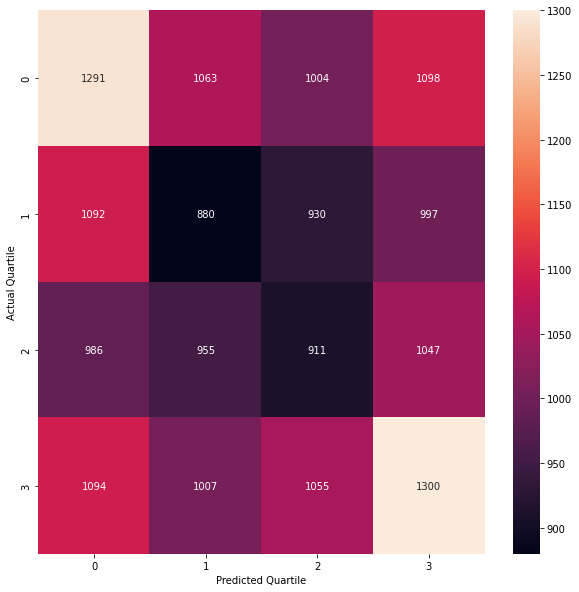

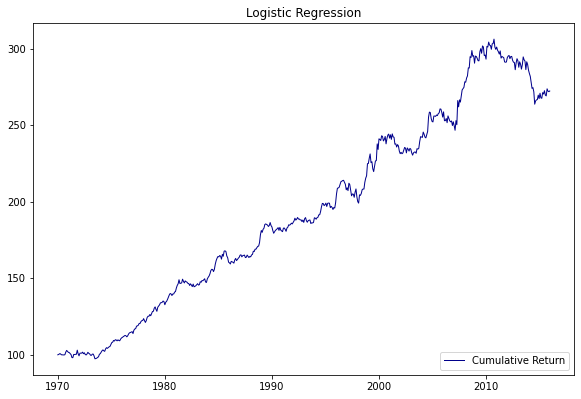

In [43]:
backtestmodel = BacktestModel(X, Y, 
                              create_model=LogisticRegression, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
mychart([backtestmodel.cumulative_return],["Cumulative Return"], title="Logistic Regression")

In [44]:
# enumerate available sklearn classifiers 
estimators = []

for name, class_ in all_estimators():
    if issubclass(class_, sklearn.base.ClassifierMixin):
        if hasattr(class_, 'predict_proba'):
            print(class_)
            estimators.append(class_)

estimators

<class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
<class 'sklearn.ensemble._bagging.BaggingClassifier'>
<class 'sklearn.naive_bayes.BernoulliNB'>
<class 'sklearn.calibration.CalibratedClassifierCV'>
<class 'sklearn.naive_bayes.CategoricalNB'>
<class 'sklearn.multioutput.ClassifierChain'>
<class 'sklearn.naive_bayes.ComplementNB'>
<class 'sklearn.tree._classes.DecisionTreeClassifier'>
<class 'sklearn.dummy.DummyClassifier'>
<class 'sklearn.tree._classes.ExtraTreeClassifier'>
<class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
<class 'sklearn.naive_bayes.GaussianNB'>
<class 'sklearn.gaussian_process._gpc.GaussianProcessClassifier'>
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
<class 'sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier'>
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
<class 'sklearn.semi_supervised._label_propagation.LabelPropagation'>
<class 'sklearn.semi_supervised._label_propagation.L

[sklearn.ensemble._weight_boosting.AdaBoostClassifier,
 sklearn.ensemble._bagging.BaggingClassifier,
 sklearn.naive_bayes.BernoulliNB,
 sklearn.calibration.CalibratedClassifierCV,
 sklearn.naive_bayes.CategoricalNB,
 sklearn.multioutput.ClassifierChain,
 sklearn.naive_bayes.ComplementNB,
 sklearn.tree._classes.DecisionTreeClassifier,
 sklearn.dummy.DummyClassifier,
 sklearn.tree._classes.ExtraTreeClassifier,
 sklearn.ensemble._forest.ExtraTreesClassifier,
 sklearn.naive_bayes.GaussianNB,
 sklearn.gaussian_process._gpc.GaussianProcessClassifier,
 sklearn.ensemble._gb.GradientBoostingClassifier,
 sklearn.ensemble._hist_gradient_boosting.gradient_boosting.HistGradientBoostingClassifier,
 sklearn.neighbors._classification.KNeighborsClassifier,
 sklearn.semi_supervised._label_propagation.LabelPropagation,
 sklearn.semi_supervised._label_propagation.LabelSpreading,
 sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
 sklearn.linear_model._logistic.LogisticRegression,
 sklearn.linear_m

In [70]:
# try various classifiers - wrap some in closure to set params
def myMLPClassifier():
    return sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(16, 16), 
                                                                      alpha=0.001, 
                                                                      max_iter=2000)
def mySGDClassifierLog():
    # needs loss="log"
    return sklearn.linear_model.stochastic_gradient.SGDClassifier(loss="log")

def mySVC():
    # needs probability=True
    return sklearn.svm.classes.SVC(probability=True)

def myXGBClassifier(n_estimators=300, max_depth=4, subsample=0.6, learning_rate=0.003):
    # needs nthreads=-1
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

def myCatBoostClassifier():
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

# at one point some reason couldn't get LightGBM sklearn interface to work, tried to wrap it in a class

class LightGbmWrapper:
    """Wrap Lightgbm model to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, 
                 param = {'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_class':3, 'metric': 'multi_logloss',},
                 num_round=10):
        self.param = param
        self.num_round = num_round
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        if len(Y_fit.shape) == 1:
            Y_fit = Y_fit.reshape(len(Y_fit), 1)
        self.nrows, self.ycols = Y_fit.shape

        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            train_data = lgb.Dataset(X_fit, label=Y_fit[:,responsecol])
            model = lgb.train(self.param, train_data, self.num_round)
            self.models.append(model)

    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows)))
        retarray = np.hstack([predictions for predictions in retlist])
        return retarray

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(np.array(Z), axis=0)
        
def myLGBMClassifier():
    def create_model():
        return lgb.LGBMClassifier(silent=True)
    return create_model

18:24:49 Generate splits [140, 280, 419, 558, 697]
classify
18:24:49 Starting training
Steps: [140, 280, 419, 558]
Training on first 140 rows (0:139), storing predictions in rows range(140, 280)
.Training on first 280 rows (0:279), storing predictions in rows range(280, 419)
.Training on first 419 rows (0:418), storing predictions in rows range(419, 558)
.Training on first 558 rows (0:557), storing predictions in rows range(558, 697)
.
best return gen params:  5
Food: long 141 times, short 80 times, total 221 times
Beer: long 74 times, short 43 times, total 117 times
Smoke: long 151 times, short 103 times, total 254 times
Games: long 152 times, short 88 times, total 240 times
Books: long 95 times, short 102 times, total 197 times
Hshld: long 135 times, short 83 times, total 218 times
Clths: long 117 times, short 106 times, total 223 times
Hlth: long 133 times, short 64 times, total 197 times
Chems: long 60 times, short 116 times, total 176 times
Txtls: long 170 times, short 108 times, 

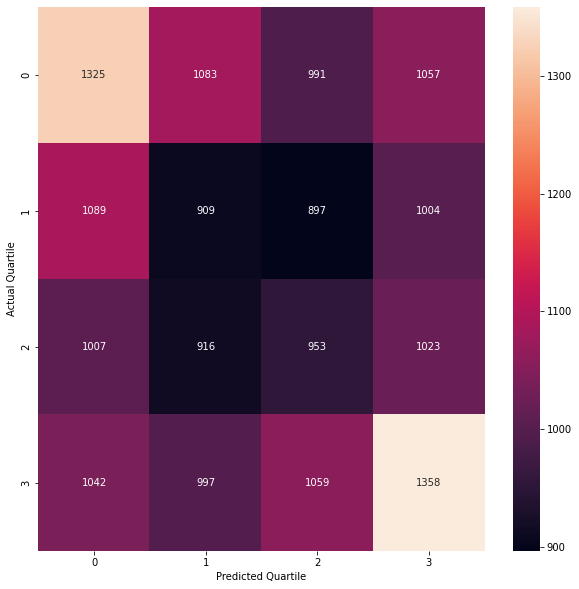

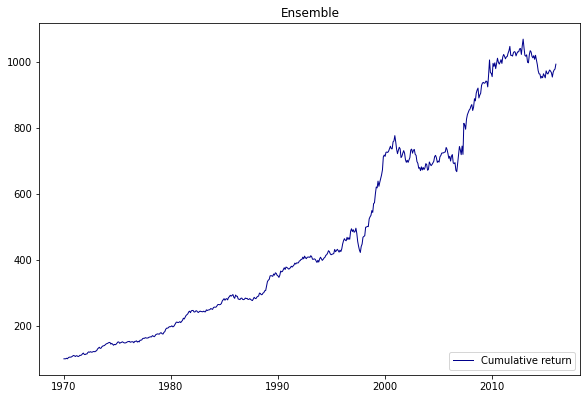

In [53]:
# create an ensemble from the best classifiers
warnings.filterwarnings("ignore")

my_ensemble = [("Logistic Regression", sklearn.linear_model.LogisticRegression()),
               ("GradientBoost", sklearn.ensemble.GradientBoostingClassifier()),
               ("AdaBoost", sklearn.ensemble.AdaBoostClassifier()),
               ("BernoulliNB", sklearn.naive_bayes.BernoulliNB()),
               ("GaussianNB", sklearn.naive_bayes.GaussianNB()),
               ("ExtraTrees", sklearn.ensemble.ExtraTreesClassifier()),
               ("LGBM", myLGBMClassifier()()),]

def myVC():
    def create_model():
        return VotingClassifier(estimators=my_ensemble,
                                voting="soft")
    return create_model

backtestmodel = BacktestModel(X, Y, 
                              create_model=myVC(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
#backtestmodel.gen_predictions() 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
mychart([backtestmodel.cumulative_return],["Cumulative return"], title="Ensemble")

In [68]:

estimators = [
              sklearn.linear_model.LogisticRegressionCV,
              #sklearn.linear_model.logistic.LogisticRegressionCV,
              #sklearn.discriminant_analysis.LinearDiscriminantAnalysis,
              #sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis,
              myMLPClassifier,
              sklearn.ensemble.GradientBoostingClassifier,
              myXGBClassifier(300, 5, 0.003, 0.6),
              myCatBoostClassifier(), # takes like 20h
              myLGBMClassifier(),
              sklearn.ensemble.AdaBoostClassifier,
              sklearn.ensemble.BaggingClassifier,
              sklearn.tree.DecisionTreeClassifier,
              sklearn.ensemble.RandomForestClassifier,
              sklearn.tree.ExtraTreeClassifier,
              sklearn.ensemble.ExtraTreesClassifier,
              sklearn.naive_bayes.BernoulliNB,
              #sklearn.calibration.CalibratedClassifierCV,
              sklearn.naive_bayes.GaussianNB,
              #sklearn.gaussian_process.gpc.GaussianProcessClassifier,
              sklearn.neighbors.KNeighborsClassifier,
              #sklearn.semi_supervised.label_propagation.LabelPropagation,
              #sklearn.semi_supervised.label_propagation.LabelSpreading,
              #sklearn.naive_bayes.MultinomialNB,
              #myNuSVC,
              #mySGDClassifierLog,
              mySVC,
              myVC(),
#              KerasBacktestModel(),
              
             ]


sklearn.linear_model._logistic.LogisticRegressionCV
<class 'type'>
create_model
18:42:26 Generate splits [140, 280, 419, 558, 697]
18:42:26 Starting training
....
best return gen params:  8
Food: long 205 times, short 36 times, total 241 times
Beer: long 105 times, short 56 times, total 161 times
Smoke: long 260 times, short 145 times, total 405 times
Games: long 114 times, short 167 times, total 281 times
Books: long 283 times, short 97 times, total 380 times
Hshld: long 176 times, short 71 times, total 247 times
Clths: long 216 times, short 171 times, total 387 times
Hlth: long 234 times, short 66 times, total 300 times
Chems: long 65 times, short 286 times, total 351 times
Txtls: long 236 times, short 143 times, total 379 times
Cnstr: long 36 times, short 120 times, total 156 times
Steel: long 0 times, short 450 times, total 450 times
FabPr: long 15 times, short 117 times, total 132 times
ElcEq: long 240 times, short 148 times, total 388 times
Autos: long 144 times, short 222 times,

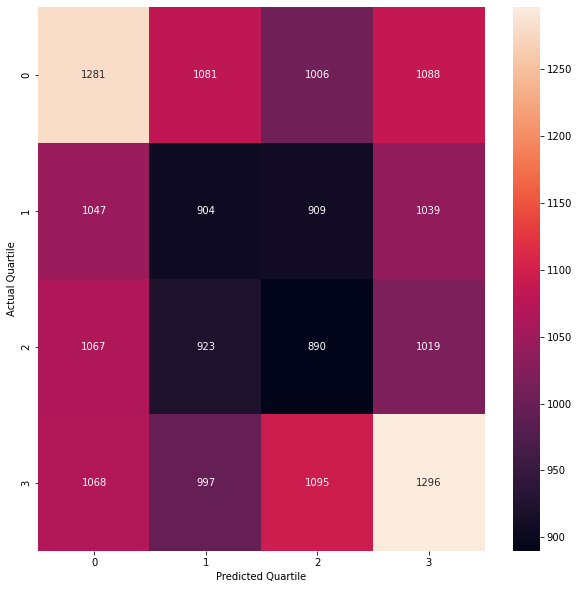

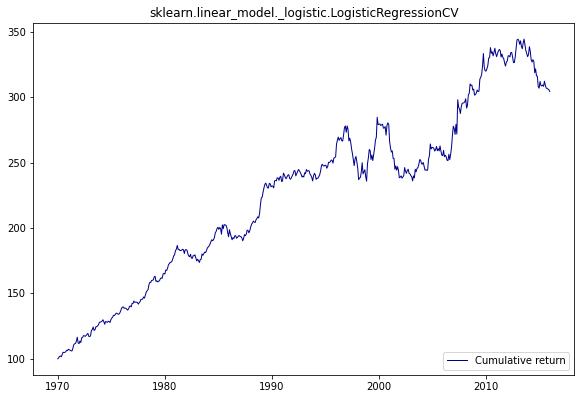

myMLPClassifier
<class 'function'>
create_model
18:45:48 Generate splits [140, 280, 419, 558, 697]
18:45:48 Starting training


AttributeError: ignored

In [73]:
est_names = []
sharpes = []
directional_accuracies=[]
in_sample_accuracies = []
cv_vals = []
kendall_taus = []
vols = []
ann_returns = []

for estimator in estimators:
    estname = str(estimator)[10:-19] if str(type(estimator))=="<class 'function'>" else str(estimator)[8:-2]
    print(estname)    
    est_names.append(estname)
    print( type(estimator))
    if callable(estimator):
        # sklearn interface, create model for each column
        print('create_model')
        backtestmodel = BacktestModel(X, Y, 
                                      create_model=estimator, 
                                      coef_dict_param="all", 
                                      startindex=FIRST_TRAIN_MONTHS,
                                      fit_missing='mean',
                                      scaler = None,
                                      make_classes=make_four_classes)
    else:
        # keras interface, use model to fit/predict all 30 at once
        print('model')
        
        backtestmodel = BacktestModel(X, Y, 
                                      model=estimator, 
                                      coef_dict_param="all", 
                                      startindex=FIRST_TRAIN_MONTHS,
                                      fit_missing='mean',
                                      scaler = None,
                                      make_classes=make_four_classes)
        
    backtestmodel.walkforward_xval(n_splits=5, verbose=False) 
    _, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16), verbose=False)
    print("best return gen params: ", best_params)
    backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes.append(backtestmodel.sharpe)
    ann_returns.append(backtestmodel.mean_return)
    vols.append(backtestmodel.annualized_vol)
    cv_vals.append(best_params)
    
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies.append(backtestmodel.directional_accuracy)
        in_sample_accuracies.append(backtestmodel.insample_accuracy)
        kendall_taus.append(backtestmodel.kendalltau)
    except:
        directional_accuracies.append(np.nan)
        in_sample_accuracies.append(np.nan)
        kendall_taus.append(np.nan)
        
    mychart([backtestmodel.cumulative_return],['Cumulative return'], title=estname)

In [ ]:
nice_names = ['Logistic Regression',
'Multilayer Perceptron',
'Gradient Boost',
'XGBClassifier',
'CatBoostClassifier',
'LGBMClassifier',
'AdaBoost',
'BaggingClassifier',
'DecisionTreeClassifier',
'RandomForestClassifier',
'ExtraTreeClassifier',
'ExtraTreesClassifier',
'Bernoulli Naive Bayes',
'Gaussian Naive Bayes',
'KNeighborsClassifier',
'Support Vector Machine',
'Sklearn Ensemble',
#'Keras Neural Network',
]

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

# nothing else seems to get the precision to display correctly 
in_sample_accuracies2 = ["%.3f" % z for z in in_sample_accuracies]
directional_accuracies2 = ["%.3f" % z for z in directional_accuracies]
kendall_taus2 = ["%.3f" % z for z in kendall_taus]
ann_returns2 = ["%.3f" % z for z in ann_returns]
vols2 = ["%.3f" % z for z in vols]
sharpes2 = ["%.3f" % z for z in sharpes]

z = pd.DataFrame(np.array([nice_names, in_sample_accuracies2, directional_accuracies2, kendall_taus2, ann_returns2, vols2, sharpes2]).T,
                 columns=['Name', 'In-Sample Acc', 'OOS Directional Acc', "Kendall's tau", 'Ann. Return', 'Vol', 'Sharpe'])
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.precision',2)
z

In [ ]:
with open('sklearn_table.html', 'w') as fo:
    z.sort_values(['Sharpe'], ascending=False).to_html(fo, float_format=lambda x: '%.3f' % x)

In [ ]:
    
myscatter(directional_accuracies, sharpes, title="Sharpe vs. Directional Accuracy")
myscatter(kendall_taus, sharpes, title="Sharpe vs. Kendall's Tau")


In [ ]:
# full backtest - train each timestep
backtestmodel = BacktestModel(X, Y, 
                              create_model=sklearn.naive_bayes.GaussianNB, 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.gen_predictions() 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
mychart([backtestmodel.cumulative_return],['Cumulative return'], title='GaussianNB')


In [ ]:
# full backtest - train each timestep
backtestmodel = BacktestModel(X, Y, 
                              create_model=myVC(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.gen_predictions() 
_, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16))
print("best return gen params: ", best_params)
backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
backtestmodel.report_returns(start_date=start_date_str, freq='M')
#backtestmodel.evaluate_predictions()
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
mychart([backtestmodel.cumulative_return],['Cumulative return'], title='Ensemble')


18:52:19 Starting training
................................................................................
19:39:14 Still training step 80 of 576
................................................................................
20:44:16 Still training step 160 of 576
................................................................................
22:08:22 Still training step 240 of 576
................................................................................
23:53:24 Still training step 320 of 576
....................................

### Perform cross-validation on Keras neural networks to select best architecture

In [ ]:
# weighted loss calculation to overweight missing by more than 1 quartile
weights = np.matrix("""
1, 0, 0, 0; 
0, 1, 0, 0; 
0, 0, 1, 0; 
0, 0, 0, 1""")

weights = np.matrix("""
0.5, 1.5, 2.5, 3.5; 
1.5, 0.5, 1.5, 2.5; 
2.5, 1.5, 0.5, 1.5; 
3.5, 2.5, 1.5, 0.5""")

actual = np.matrix("1.0, 0.0, 0.0, 0.0")
predicted = np.matrix("0.4, 0.3, 0.2, 0.1")
print(actual.dot(weights))
log_loss = -np.log(actual.dot(predicted.T))
print(log_loss)
raw_loss = - np.log(np.multiply(actual, predicted) + np.multiply(1 - actual, 1 - predicted))
print(raw_loss)
print(np.multiply(raw_loss, actual.dot(weights) ))
print(np.sum(np.multiply(raw_loss, actual.dot(weights) )))

weighted_loss = actual.dot(weights).dot(raw_loss.T)
weighted_loss

In [ ]:
# custom loss function
# apply weights on categorical cross-entropy to penalize wronger answers by more
weights = np.matrix("""
0.5, 1.5, 2.5, 3.5; 
1.5, 0.5, 1.5, 2.5; 
2.5, 1.5, 0.5, 1.5; 
3.5, 2.5, 1.5, 0.5""")

weights = np.matrix("""
1, 0, 0, 0; 
0, 1, 0, 0; 
0, 0, 1, 0; 
0, 0, 0, 1""")

weights = tf.constant(np.array(weights),dtype=tf.float32)

def my_categorical_cross_entropy(target, output, from_logits=False, axis=-1):
    """Categorical crossentropy between an output tensor and a target tensor.
    # Arguments
        target: A tensor of the same shape as `output`.
        output: A tensor resulting from a softmax
            (unless `from_logits` is True, in which
            case `output` is expected to be the logits).
        from_logits: Boolean, whether `output` is the
            result of a softmax, or is a tensor of logits.
        axis: Int specifying the channels axis. `axis=-1`
            corresponds to data format `channels_last`,
            and `axis=1` corresponds to data format
            `channels_first`.
    # Returns
        Output tensor.
    # Raises
        ValueError: if `axis` is neither -1 nor one of
            the axes of `output`.
    """
    output /= tf.reduce_sum(output, axis, True)
    # manual computation of crossentropy
    _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
    raw_loss = - tf.log(target * output + (1 - target) * (1 - output))
    weight_array = tf.matmul(target, weights)
    weighted_loss = weight_array * raw_loss
    
    return tf.reduce_sum(weighted_loss, axis)

actual = tf.constant(np.array(np.matrix("1.0, 0.0, 0.0, 0.0")),dtype=tf.float32)
predicted = tf.constant(np.array(np.matrix("0.4, 0.3, 0.2, 0.1")),dtype=tf.float32)
test_my_categorical_cross_entropy = my_categorical_cross_entropy(actual, predicted)

with tf.Session() as mysess:
    print(mysess.run(test_my_categorical_cross_entropy))

In [ ]:
EPOCHS=2000
INPUT_DIM=X.shape[1]
OUTPUT_DIM=30
BATCH_SIZE=64
NCLASSES=4

class KerasBacktestModel(object):

    def __init__(self, 
                 n_hidden_layers = 2,
                 hidden_layer_size = 8,
                 reg_penalty = 0.001,
                 epochs=EPOCHS,
                 loss_function = "categorical_crossentropy",
                 verbose=True):
        
        self.epochs=epochs
        
        main_input = Input(shape=(INPUT_DIM,),
                           dtype='float32', 
                           name='main_input')
        lastlayer=main_input
        
        for i in range(n_hidden_layers):
            if verbose:
                print("layer %d size %d, reg_penalty %.8f" % (i + 1, 
                                                              hidden_layer_size, 
                                                              reg_penalty, 
                                                             ))
            lastlayer = Dense(units = hidden_layer_size, 
                              activation = 'relu',
                              kernel_initializer = keras.initializers.glorot_uniform(),
                              kernel_regularizer=keras.regularizers.l1_l2(reg_penalty),
                              name = "Dense%02d" % i)(lastlayer)
            
        outputs = []
        for i in range(OUTPUT_DIM):
            outputs.append(Dense(NCLASSES, activation='softmax', name = "Output%02d" % i)(lastlayer))
            
        self.model = Model(inputs=[main_input], outputs=outputs)
        if verbose:
            print(self.model.summary())
            
        self.model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])
        
    def fit(self, X, Y, epochs=None, verbose=False):
        # convert Y to list of ys
        Y_list = [keras.utils.to_categorical(Y[:,i], num_classes=NCLASSES) for i in range(OUTPUT_DIM)]

        if epochs:
            self.epochs = epochs

        retval = self.model.fit(X,
                                Y_list,
                                batch_size=BATCH_SIZE,
                                epochs=self.epochs,
                                verbose=False)
        self.history = retval.history
        self.last_loss_array = self.history['loss']
        self.last_loss = self.history['loss'][-1] # includes regularization loss
        return retval
    
    
    def predict_proba(self, X, verbose=False):
        y_list = self.model.predict(X)
        #print("List of %d arrays of shape %s" % (len(y_list), str(y_list[0].shape)))
        return [np.vstack([y_list[j][:,i] for j in range(OUTPUT_DIM)]).T for i in range(NCLASSES)]
    
    def predict(self, X, verbose=False):
        Y_pred = self.predict_proba(X)
        ys = []
        for col in range(OUTPUT_DIM):
            ys.append(np.argmax(np.vstack([Y_pred[cl][:,col] for cl in range(NCLASSES)]).T, axis=1))
        retarray = np.vstack(ys).T
        #print(retarray.shape)
        return(retarray)    
    
    def save(self, modelname):
        self.model.save("%s.h5" % modelname)
        self.model.save_weights("%s_weights.h5" % modelname)

In [ ]:
# Wrap our Keras model in sklearn interface for VotingClassifier. 
# Not used here because too slow, sklearn interface models one response at a time instead of all 30 
# but recorded for posterity

# KerasClassifier wraps a Keras model with an sklearn interface
# But it returns wrong shape for VotingClassifier ensemble
# 2D shape (nrows,1) instead of 1D (nrows) 
# Subclass KerasClassifier and override predict  

def modelFactory(n_hidden_layers = 2,
                 hidden_layer_size = 8,
                 reg_penalty = 0.001,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return myKerasClassifier(n_hidden_layers,
                                 hidden_layer_size,
                                 reg_penalty,
                                 epochs,
                                 verbose)
    return create_fn

class monkeyKerasClassifier(KerasClassifier):
    """subclass KerasClassifier and override predict to work with VotingClassifier"""
    def __init__(self, *args, **kwargs):
        super(KerasClassifier, self).__init__(*args, **kwargs)        
        
    def predict(self, x, **kwargs):
        pred = KerasClassifier.predict(self, x, **kwargs)
        return pred[:, 0]
        
def kerasClassifierFactory(n_hidden_layers = 2,
                           hidden_layer_size = 8,
                           reg_penalty = 0.001,
                           epochs=EPOCHS,
                           verbose=True):
    def create_fn():
        return monkeyKerasClassifier(build_fn=modelFactory(n_hidden_layers,
                                                     hidden_layer_size,
                                                     reg_penalty,
                                                     epochs,
                                                     verbose), 
                               epochs=EPOCHS, 
                               batch_size=100, 
                               verbose=0)
    return create_fn

In [ ]:
# default loss function
n_hiddens = [1, 2, 3]
layer_sizes = [4, 8, 16]
reg_penalties = [0.0, 0.1]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

keys = []

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    nlayers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (nlayers, layer_size, reg_penalty)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  model=KerasBacktestModel(n_hidden_layers = nlayers,
                                                           hidden_layer_size = layer_size,
                                                           reg_penalty = reg_penalty,
                                                          ), 
                                  coef_dict_param="all",
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    _, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16), verbose=False)
    print("best return gen params: ", best_params)
    backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_quantiles(chart=True, verbose=True)
    mychart([backtestmodel.cumulative_return],["Cumulative return"], title=str(param_list))

    print("---")
    


In [ ]:
# custom loss function
n_hiddens = [1, 2, 3]
layer_sizes = [8, 16]
reg_penalties = [0.0, 0.1, 1.0]
hyperparameter_combos = list(product(n_hiddens, layer_sizes, reg_penalties))

keys = []

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    nlayers, layer_size, reg_penalty = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (nlayers, layer_size, reg_penalty)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  model=KerasBacktestModel(n_hidden_layers = nlayers,
                                                           hidden_layer_size = layer_size,
                                                           reg_penalty = reg_penalty,
                                                           loss_function = my_categorical_cross_entropy
                                                          ), 
                                  coef_dict_param="all",
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    _, best_params = backtestmodel.sharpe_cv(calc_returns_gen, range(1, 16), verbose=False)
    print("best return gen params: ", best_params)
    backtestmodel.gen_returns(calc_returns_gen(best_params), verbose=True)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    backtestmodel.evaluate_quantiles(chart=True, verbose=True)
    mychart([backtestmodel.cumulative_return],["Cumulative return"], title=str(param_list))

    print("---")
    


In [ ]:
# tune XGBClassifier

keys = []
sharpes2 = []
directional_accuracies2=[]
in_sample_accuracies2 = []

n_estimators_list = [100, 300, 1000]
max_depth_list = [3,4,5,6]
learning_rate_list = [0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001]
subsample_list = [0.6, 0.7, 0.8]
hyperparameter_combos = list(product(n_estimators_list, max_depth_list, learning_rate_list, subsample_list))

def myXGBClassifier(n_estimators, max_depth, subsample, learning_rate):
    def create_model():
        return xgboost.sklearn.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, subsample=subsample, learning_rate=learning_rate, nthreads=-1)
    return create_model

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    n_estimators, max_depth, subsample, learning_rate = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_estimators, max_depth, subsample, learning_rate)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=myXGBClassifier(n_estimators,max_depth,subsample,learning_rate), 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    # backtestmodel.gen_predictions_classify(verbose=False)
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes2.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies2.append(backtestmodel.directional_accuracy)
        in_sample_accuracies2.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies2.append(np.nan)
        in_sample_accuracies2.append(np.nan)

    print("---")

In [ ]:
# fix display precision
metricsframe = pd.DataFrame(list(zip(["%d" % k[0] for k in keys],
                                     ["%d" % k[1] for k in keys],
                                     ["%.5f" % k[2] for k in keys],
                                     ["%.3f" % k[3] for k in keys],
                                     ["%.4f" % z for z in in_sample_accuracies2],
                                     ["%.4f" % z for z in directional_accuracies2],
                                     ["%.3f" % z for z in sharpes2])), 
                            columns = ['n_estimators', 'max_depth', 'learning_rate', 'subsample','in_sample_acc','oos_acc','sharpe'])

in_sample_accuracies2 = ["%.3f" % z for z in in_sample_accuracies]
directional_accuracies2 = ["%.3f" % z for z in directional_accuracies]
kendall_taus2 = ["%.3f" % z for z in kendall_taus]
ann_returns2 = ["%.3f" % z for z in ann_returns]
vols2 = ["%.3f" % z for z in vols]
sharpes2 = ["%.3f" % z for z in sharpes]

metricsframe

In [ ]:
metricsframe.sort_values(["oos_acc"])

In [ ]:
pd.DataFrame(metricsframe.groupby(['n_estimators'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['max_depth'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['subsample'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
pd.DataFrame(metricsframe.groupby(['learning_rate'])[['in_sample_acc', 'oos_acc', 'sharpe']].mean())

In [ ]:
model = catboost.CatBoostClassifier()

keys = []
sharpes3 = []
directional_accuracies3=[]
in_sample_accuracies3 = []

n_estimators_list = [1000]
max_depth_list = [4]
learning_rate_list = [0.001]
subsample_list = [0.7]
hyperparameter_combos = list(product(n_estimators_list, max_depth_list, learning_rate_list, subsample_list))

def myCatClassifier(n_estimators=1000, max_depth=4, subsample=0.7, learning_rate=0.001):
    def create_model():
        #return catboost.CatBoostClassifier(iterations=n_estimators, learning_rate=learning_rate, depth=max_depth, rsm=subsample, 
        #                                   thread_count=6, loss_function='MultiClass', task_type='CPU', logging_level='Silent')
        return catboost.CatBoostClassifier(loss_function='MultiClass', task_type='CPU', logging_level='Silent')
    return create_model

print("%s Running %d experiments" % (time.strftime("%H:%M:%S"), len(hyperparameter_combos)))
for counter, param_list in enumerate(hyperparameter_combos):
    n_estimators, max_depth, subsample, learning_rate = param_list
    print("%s Running experiment %d of %d" % (time.strftime("%H:%M:%S"), counter+1, len(hyperparameter_combos)))
    key = (n_estimators, max_depth, subsample, learning_rate)
    print(key)
    keys.append(key)
    backtestmodel = BacktestModel(X, Y, 
                                  create_model=myCatClassifier(n_estimators,max_depth,subsample,learning_rate), 
                                  coef_dict_param="all", 
                                  startindex=FIRST_TRAIN_MONTHS,
                                  fit_missing='mean',
                                  scaler = None,
                                  make_classes=make_four_classes)
    #backtestmodel.gen_predictions_classify(verbose=False)
    backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
    backtestmodel.gen_returns(calc_returns, verbose=False)
    backtestmodel.report_returns(start_date=start_date_str, freq='M')
    sharpes3.append(backtestmodel.sharpe)
    try:
        backtestmodel.evaluate_quantiles(chart=True, verbose=True)
        directional_accuracies3.append(backtestmodel.directional_accuracy)
        in_sample_accuracies3.append(backtestmodel.insample_accuracy)
    except:
        directional_accuracies3.append(np.nan)
        in_sample_accuracies3.append(np.nan)

    print("---")

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print(backtestmodel.directional_accuracy)
print(backtestmodel.insample_accuracy)
 

In [ ]:

class LightGbmWrapper:
    """Wrap Lightgbm model to fit, predict all vars as a vector, 
    match the way our Keras model will do it. No coef_dict"""

    def __init__(self, 
                 param = {'num_leaves':31, 'num_trees':100, 'objective':'multiclass', 'num_class':4, 'metric': 'multi_logloss',},
                 num_round=10):
        self.param = param
        self.num_round = num_round
        self.models = []
        
    def fit(self, X_fit, Y_fit, verbose=False):
        
        self.nrows, self.ycols = Y_fit.shape
        #print("%d rows x %d cols" % (self.nrows, self.ycols))
        self.nclasses = np.unique(Y_fit).shape[0]
        self.models = []
        # fit model for each column
        for responsecol in range(self.ycols):
            train_data = lgb.Dataset(X_fit, label=Y_fit[:,responsecol])
            model = lgb.train(self.param, train_data, self.num_round)
            self.models.append(model)

    def predict_proba(self, X_predict, verbose=False):

        """return a list of length nclasses with probs for each class"""
        retlist = [list() for i in range(self.nclasses)]
        nrows = X_predict.shape[0]

        for responsecol in range(self.ycols):
            y_pred = self.models[responsecol].predict(X_predict)
            for classcol in range(self.nclasses):
                retlist[classcol].append((y_pred[:,classcol].reshape(nrows,1)))
        return [np.hstack(predictions) for predictions in retlist]

    def predict(self, X_predict, verbose=False):
        Z = self.predict_proba(X_predict)
        return np.argmax(np.array(Z), axis=0)
        
        

In [ ]:
backtestmodel = BacktestModel(X, Y, 
                              model=LightGbmWrapper(), 
                              coef_dict_param="all", 
                              startindex=FIRST_TRAIN_MONTHS,
                              fit_missing='mean',
                              scaler = None,
                              make_classes=make_four_classes)
backtestmodel.gen_predictions_classify(verbose=False)
#backtestmodel.walkforward_xval(n_splits=5, verbose=True) 
backtestmodel.gen_returns(calc_returns, verbose=False)

backtestmodel.report_returns(start_date=start_date_str, freq='M')
backtestmodel.evaluate_quantiles(chart=True, verbose=True)
print("OOS Accuracy: %.4f" % backtestmodel.directional_accuracy)
print("In-Sample Accuracy: %.4f" % backtestmodel.insample_accuracy)